In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms


In [9]:
BATCH_SIZE = 16

train_data = MNIST("./test_data", 
                   train=True, 
                   download=True, 
                   transform=transforms.ToTensor())

train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
print("train data size: ",len(train_data))   #train data size:  60000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  3750


train data size:  60000
train iteration number:  3750


images_size: torch.Size([16, 1, 28, 28])
label: tensor([7, 0, 5, 7, 7, 4, 2, 1, 6, 0, 7, 7, 0, 1, 0, 6])


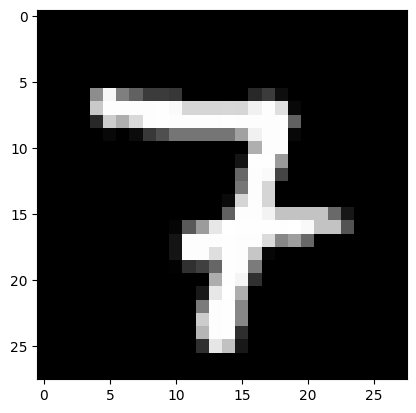

In [10]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([16, 1, 28, 28])
print("label:",labels)   #label: tensor([7, 3, 0, 3, 7, 2, 5, 3, 2, 0, 8, 7, 4, 9, 5, 7])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')


In [11]:
class TwoConvBlock_2D(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding="same")
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.rl = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding="same")
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.rl(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.rl(x)
    return x

class Discriminator(nn.Module):   #識別器
  def __init__(self):
    super().__init__()
    self.conv1 = TwoConvBlock_2D(1,64)
    self.conv2 = TwoConvBlock_2D(64, 128)
    self.conv3 = TwoConvBlock_2D(128, 256)

    self.avgpool_2D = nn.AvgPool2d(2, stride = 2)
    self.global_avgpool_2D = nn.AvgPool2d(7)

    self.l1 = nn.Linear(256, 20)
    self.l2 = nn.Linear(20, 1)
    self.rl = nn.LeakyReLU()
    self.dropout1 = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.1)
    self.embed = nn.Embedding(10, 256)

  def forward(self, x, y):
    x = self.conv1(x)
    x = self.avgpool_2D(x)
    x = self.conv2(x)
    x = self.avgpool_2D(x)
    x = self.conv3(x)
    x = self.global_avgpool_2D(x)
    x = x.view(-1, 256)
    _x = x
    x = self.dropout1(x)
    x = self.l1(x)
    x = self.rl(x)
    x = self.dropout2(x)
    x = self.l2(x)

    _y = self.embed(y)   #ラベルをembedding層で埋め込む
    xy = (_x*_y).sum(1, keepdim=True)   #出力ベクトルとの内積をとる

    x = x+xy   #内積を加算する
    x = torch.sigmoid(x)
    return x

class Generator(nn.Module):   #生成器
  def __init__(self):
    super().__init__()
    self.l = nn.Linear(110, 49)
    self.dropout = nn.Dropout(0.2)
    self.TCB1 = TwoConvBlock_2D(1,512)
    self.TCB2 = TwoConvBlock_2D(512,256)
    self.TCB3 = TwoConvBlock_2D(256,128)
    self.UC1 = nn.ConvTranspose2d(512, 512, kernel_size =2, stride = 2)
    self.UC2 = nn.ConvTranspose2d(256, 256, kernel_size =2, stride = 2)
    self.conv1 = nn.Conv2d(128, 1, kernel_size = 2, padding="same")
  

  def forward(self, x, y):
    y = torch.nn.functional.one_hot(y.long(), num_classes=10).to(torch.float32)
    x = torch.cat([x, y], dim= 1)
    x = self.dropout(x)
    x = self.l(x)
    x = torch.reshape(x, (-1, 1, 7, 7))
    x = self.TCB1(x)
    x = self.UC1(x)
    x = self.TCB2(x)
    x = self.UC2(x)
    x = self.TCB3(x)
    x = self.conv1(x)
    x = torch.sigmoid(x)
    return x


In [12]:
def get_device_name():
    if torch.cuda.is_available():
        return "cuda:0"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [13]:
device = torch.device(get_device_name())   #GPUを設定
model_D = Discriminator().to(device)
model_G = Generator().to(device)

true_labels = torch.ones(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)   #1のラベル
fake_labels = torch.zeros(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)   #0のラベル

criterion = nn.BCELoss()    #損失関数はBCE(Binary Cross Entropy)を使用

optimizer_D = optim.Adam(model_D.parameters(), lr=0.00001)   #最適化関数はAdamを使用
optimizer_G = optim.Adam(model_G.parameters(), lr=0.00001)

epoch_num = 10   #エポック数（同じデータセットを何回学習するか）
print_coef = 10
G_train_ratio = 2   #識別器の学習1回あたり生成器が学習する回数
train_length = len(train_data)

def calc_acc(pred):   #正解率の評価関数
  pred = torch.where(pred > 0.5, 1., 0.)
  acc = pred.sum()/pred.size()[0]
  return acc

history = {"loss_D": [], "loss_G": [], "acc_true": [], "acc_fake": []}
n = 0
m = 0

for epoch in range(epoch_num):
  train_loss_D = 0
  train_loss_G = 0
  train_acc_true = 0
  train_acc_fake = 0

  model_D.train()
  model_G.train()
  for i, data in enumerate(train_loader):
    optimizer_D.zero_grad()
    inputs, labels = data[0].to(device), data[1].to(device)

    #識別器の学習（1）
    outputs = model_D(inputs, labels)   #本物の画像が本物か偽物か判定
    loss_true = criterion(outputs, true_labels)   #本物のデータを本物と判定するように学習したいので1のラベルを使用
    acc_true = calc_acc(outputs)

    #識別器の学習（2）
    noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)   #ランダムな配列を生成
    noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)   #1~9のランダムな整数を生成
    inputs_fake = model_G(noise, noise_label).to(device)   #偽物の画像を生成
    outputs_fake = model_D(inputs_fake.detach(), noise_label)   #偽物の画像が本物か偽物か判定
    loss_fake = criterion(outputs_fake, fake_labels)   #偽物の画像を偽物と判定する方向に学習したいので0のラベルを使用
    acc_fake = calc_acc(outputs_fake)
    loss_D = loss_true + loss_fake   #識別器の学習（1）・（2）の損失を足し合わせる
    loss_D.backward()
    optimizer_D.step()   #識別器のパラメータを更新する

    #生成器の学習
    for _ in range(G_train_ratio):   #G_train_ratioの回数分生成器の学習を繰り返す
      optimizer_G.zero_grad()
      noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)  #ランダムな配列を生成
      noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)   #1~9のランダムな整数を生成
      inputs_fake = model_G(noise, noise_label).to(device)
      outputs_fake = model_D(inputs_fake, noise_label)
      loss_G = criterion(outputs_fake, true_labels)   #本物と判定される偽物の画像を生成したいので1のラベルを使用
      loss_G.backward()
      optimizer_G.step()   #生成器のパラメータを更新する

    #学習経過の保存
    train_loss_D += loss_D.item()
    train_loss_G += loss_G.item()
    train_acc_true += acc_true.item()
    train_acc_fake += acc_fake.item()
    n += 1
    history["loss_D"].append(loss_D.item())
    history["loss_G"].append(loss_G.item())
    history["acc_true"].append(acc_true.item())
    history["acc_fake"].append(acc_fake.item())

    if i % ((train_length//BATCH_SIZE)//print_coef) == (train_length//BATCH_SIZE)//print_coef - 1:
      print(f"epoch:{epoch+1}  index:{i+1}  loss_D:{train_loss_D/n:.10f}  loss_G:{train_loss_G/n:.10f}  acc_true:{train_acc_true/n:.10f}  acc_fake:{train_acc_fake/n:.10f}")

      n = 0
      train_loss_D = 0
      train_loss_G = 0
      train_acc_true = 0
      train_acc_fake = 0

print("finish training")


epoch:1  index:375  loss_D:6.4501561887  loss_G:3.7694112692  acc_true:0.8518333333  acc_fake:0.3336666667
epoch:1  index:750  loss_D:6.9229349897  loss_G:4.0315377165  acc_true:0.9631666667  acc_fake:0.2718333333
epoch:1  index:1125  loss_D:6.5925845586  loss_G:4.2967906173  acc_true:0.9738333333  acc_fake:0.1801666667
epoch:1  index:1500  loss_D:6.1117482694  loss_G:4.5462406031  acc_true:0.9781666667  acc_fake:0.1606666667
epoch:1  index:1875  loss_D:4.5351852207  loss_G:4.7726741066  acc_true:0.9806666667  acc_fake:0.1181666667
epoch:1  index:2250  loss_D:4.3386642365  loss_G:4.8493059597  acc_true:0.9825000000  acc_fake:0.1168333333
epoch:1  index:2625  loss_D:2.8842696956  loss_G:4.7535715453  acc_true:0.9800000000  acc_fake:0.0998333333
epoch:1  index:3000  loss_D:0.8984601100  loss_G:4.7004837914  acc_true:0.9838333333  acc_fake:0.0453333333
epoch:1  index:3375  loss_D:0.2685861076  loss_G:4.7203382727  acc_true:0.9828333333  acc_fake:0.0683333333
epoch:1  index:3750  loss_D:0.

KeyboardInterrupt: 

Text(0, 0.5, 'loss_G')

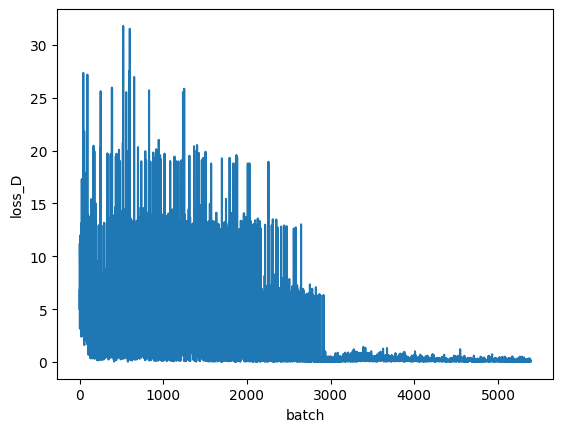

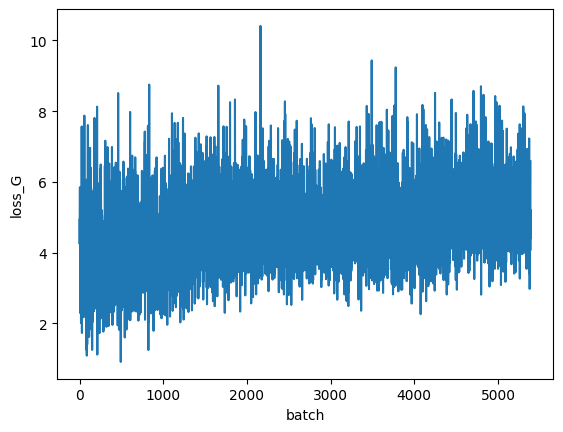

In [14]:
plt.figure()
plt.plot(history["loss_D"])
plt.xlabel('batch')
plt.ylabel('loss_D')

plt.figure()
plt.plot(history["loss_G"])
plt.xlabel('batch')
plt.ylabel('loss_G')


<Figure size 640x480 with 0 Axes>

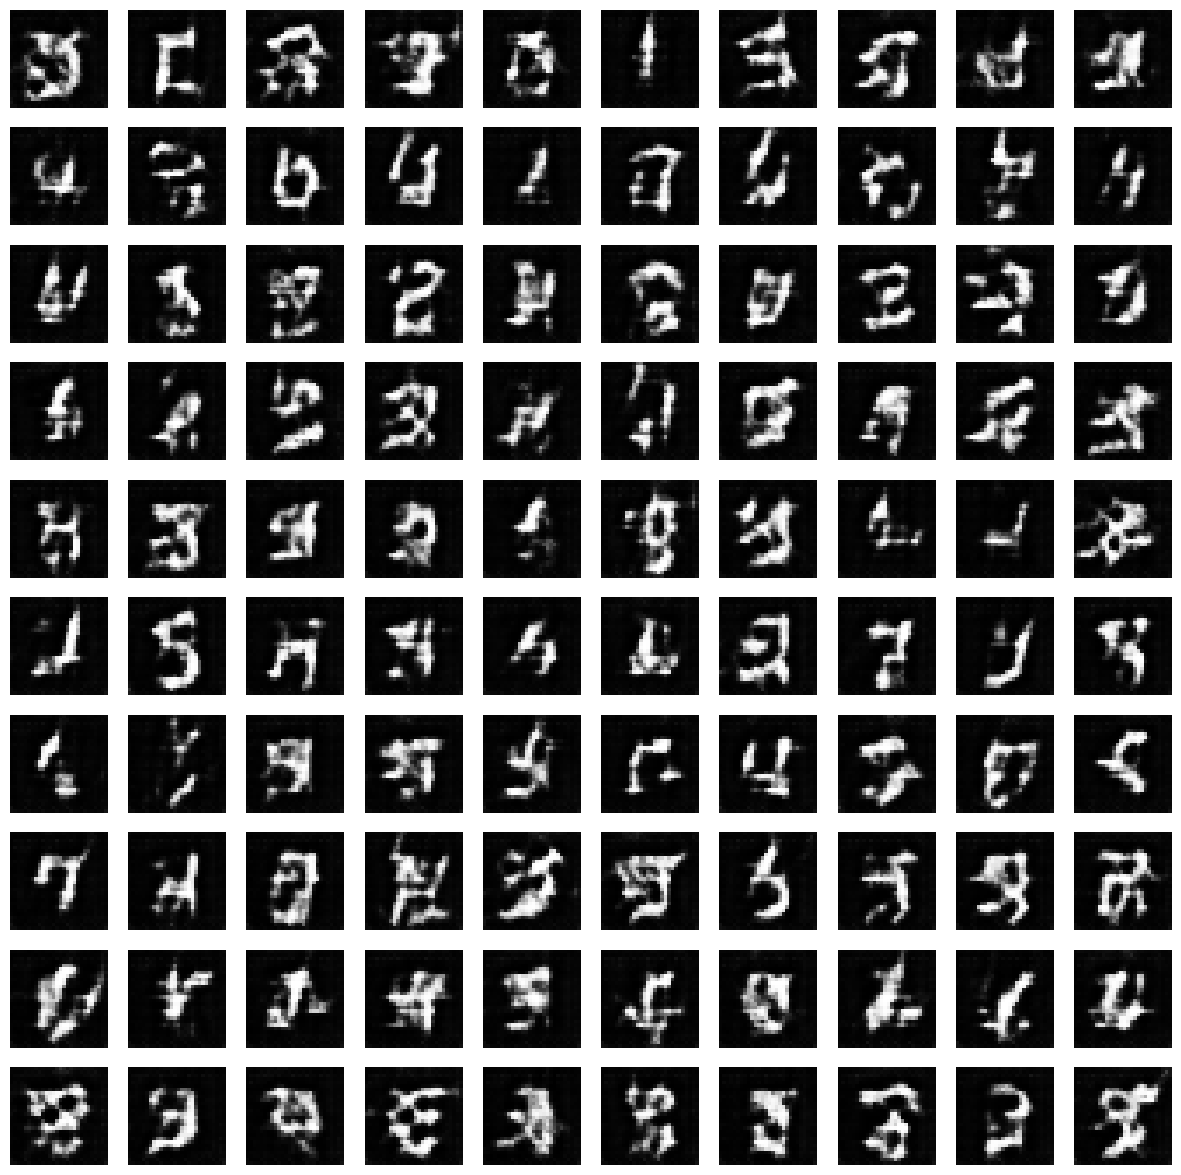

In [15]:
for i in range(10):
  intnp = np.random.randint(i ,i + 1 ,10)
  if i == 0:
    label_np = intnp
  else:
    label_np = np.concatenate([label_np, intnp], 0)

model_G.to("cpu")
with torch.no_grad():
  noise = torch.randn((100, 100), dtype=torch.float32)
  noise_label = torch.from_numpy(label_np).clone()
  syn_image = model_G(noise, noise_label)
  
  plt.figure()
  fig, ax = plt.subplots(10, 10, figsize=(15,15))
  for i in range(10):
    for j in range(10):
        ax[i,j].imshow(syn_image[i * 10 + j,0,:,:], cmap='gray')
        ax[i,j].axis("off")
